<a href="https://colab.research.google.com/github/glamacles/notebooks/blob/main/gaussian_processes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction



- We're familiar with random variables.
- For example a multivariate Gaussian:
$$\pmb{y} \sim \mathcal{N}(\pmb{\mu}, \Sigma)$$
$$ P(\pmb{y}) = (2 \pi)^{-n/2} |\Sigma|^{-1/2} \exp \left ( -\frac{1}{2} (\pmb{y} - \pmb{\mu})^T \Sigma^{-1} (\pmb{y} - \pmb{\mu}) \right ) $$
- Samples are points in $n$-dimensional space
- A 2D example:

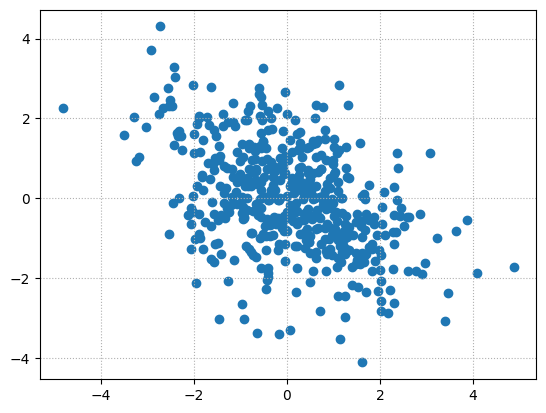

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

x0 = np.array([0., 0.])
sigma = np.array([
    [2., -1],
    [-1, 2.]
])

ys = np.random.multivariate_normal(x0, sigma, 500)
plt.scatter(ys[:,0], ys[:,1])
plt.grid(True, linestyle=':')

# Gaussian Processes


- A Gaussian process can be thought of as a distribution over functions
- Samples are functions instead of points!
- A Gaussian process is fully defined by a mean function $m(x)$ and a kernel $k(x,x')$
- Kernel represents relationship between "nearby" points
- Example: Radial Basis Function (RBF) Kernel
 $$k(x, x') = \sigma^2 \exp \left ( \frac{|| x - x' ||^2 }{ 2 l^2 }\right )$$
- Below we'll draw samples from a GP with $m(x)=0$ and an RBF kernel


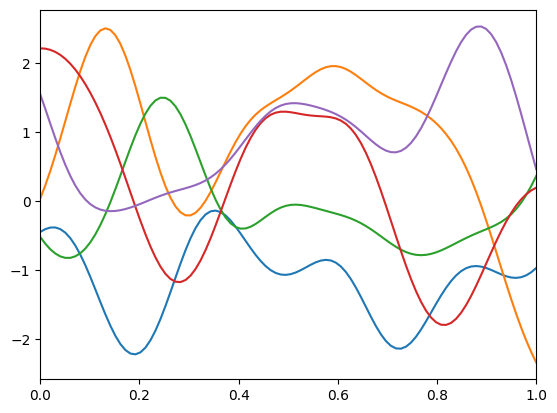

In [4]:
# X coords
xs = np.linspace(0.,1.,100)

# Kernel Matrix
d = distance_matrix(xs[:,np.newaxis], xs[:,np.newaxis], p=2)
# Variance
sigma = 1.
# Length scale
l = 0.1
# Kernel
K = sigma**2 * np.exp(-d**2 / (2*l**2))

# Plot realizations
ys = np.random.multivariate_normal(np.zeros_like(xs), K, 500)
for i in range(5):
    plt.plot(xs, ys[i])
    plt.xlim([0.,1.])


## Properties
- Mean function $m(x)$ defines the mean of the distribution of functions at a given point
- Kernel $k(x,x')$ often characterizes the variance and "smoothness" of the random functions
- Other choices for the kernel can encode other useful assumptions about the properties of the random functions (more later)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from ipywidgets import interact

def plot_function(sigma, l):
    xs = np.linspace(0.,1.,100)

    # Kernel Matrix
    d = distance_matrix(xs[:,np.newaxis], xs[:,np.newaxis], p=2)
    # Kernel
    K = sigma**2 * np.exp(-d**2 / (2*l**2))

    ys = np.random.multivariate_normal(np.zeros_like(xs), K, 5)

    plt.clf()
    for i in range(5):
        plt.plot(xs, ys[i])
    plt.xlim([0.,1.])
    plt.ylim([-2, 2])
    plt.show()

interact(plot_function, sigma=(0.01, 1.), l=(0.01,1.))

interactive(children=(FloatSlider(value=0.505, description='sigma', max=1.0, min=0.01), FloatSlider(value=0.50…

<function __main__.plot_function(sigma, l)>

- A collection of random variables $f(x), \cdots, f(x_n)$ is said to be drawn from a GP with mean $m(x)$ and covariance function $k(x,x')$ if they have the distribution
$$\pmb{f} \sim \mathcal{N} \left ( \pmb{m}, K \right ) $$

where
$$ \pmb{f} = [f(x_1), f(x_2), \cdots, f(x_n)]^T$$
$$ \pmb{m} = [m(x_1), m(x_2), \cdots, m(x_n)]^Y$$
$$
K =
\begin{bmatrix}
k(x_1, x_1) & \cdots & k(x_1, x_n) \\
\vdots & \ddots & \vdots \\
k(x_n, x_1) & \cdots & k(x_n, x_n)
\end{bmatrix} $$
- That is, if we take any set of points $x_1, x_2, \cdots, x_n$, the random variables corresponding to those points $f(x_1), f(x_2), \cdots, f(x_n)$ follow a multivariate Gaussian distribution
- e.g. if we look at two points, we get 2d Gaussian

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact


def plot_function(i0, i1):
    plt.clf()

    plt.subplot(2,1,1)
    for i in range(25):
        plt.plot(xs, ys[i])
        plt.plot([xs[i0], xs[i1]], [ys[i,i0], ys[i,i1]], 'ko')
    plt.xlim([0,1.])

    plt.subplot(2,1,2)
    plt.scatter(ys[:,i0], ys[:,i1])
    plt.show()

interact(plot_function, i0=(0, 99), i1=(0, 99))


interactive(children=(IntSlider(value=49, description='i0', max=99), IntSlider(value=49, description='i1', max…

<function __main__.plot_function(i0, i1)>

# Gaussian Process Regression



## Scenario
- Suppose we have some noisy observations of an unknown function $F : \pmb{x} \to \pmb{y}$ with $ x \in \mathcal{R}^n$ and $y \in \mathcal{R}$
$$ \pmb{y} = F(X) + \pmb{\epsilon} $$
- Here, we have
$$ \epsilon \sim \mathcal{N} \left ( \pmb{0}, \sigma^2 I \right ) $$
$$ X = [\pmb{x_1}, \cdots, \pmb{x_{N_0}}] $$
$$ \pmb{y} = [F(\pmb{x_1}), \cdots, F(\pmb{x_{N_0}})] $$
- Suppose we want to predict outputs of $F$ at unknown locations
$$ \pmb{y_*} = F(X^*) $$
- where
$$X_* = [\pmb{x_1}_*, \cdots, \pmb{x_{N_1}}_*]$$

## Joint Distribution
- GP regression makes the assumption that the observations arise from some GP with a zero mean and given covariance kernel $k(x,x')$
- Under this assumption, the joint distribution of all points (observed $X$, and unobserved $X_*$) is Gaussian
$$ \begin{bmatrix}
\pmb{y} \\
\pmb{y_*}
\end{bmatrix}
\sim
\mathcal{N} \left ( \pmb{0},
\begin{bmatrix}
 K(X,X) + \sigma^2 I & K(X,X_*)\\
 K(X_*, X) & K(X_*, X_*)
\end{bmatrix}
\right )$$
- The notation $K(X, X_*)$ is shorthand for the given covariance matrix
$$
K(X, X_*) = \begin{bmatrix}
 k(x_1, {x_1}_*) & \cdots & k(x_1, {x_{N_1}}_*) \\
 \vdots & \ddots & \vdots \\
 k(x_{N_0}, {x_1}_*) & \cdots & k(x_{N_0}, {x_{N_1}}_*)
\end{bmatrix}
$$
- $K(X,X)$ and $K(X_*,X)$ are defined similarly

## Prediction: Computing the Conditional Distribution
- From here can estimate the distribution for the unknown random variables $\pmb{y_*}$ at the unobserved points $X^*$ by conditioning on the observations
- This yields gives us an estimate of mean and covariance
$$ \pmb{y}^* \sim \mathcal{N}( \pmb{m}, P) $$
$$ \pmb{m} = K(X_*, X) \left ( K(X, X) + \sigma^2 I)^{-1} K(X, X^*) \right ) \pmb{y} $$
$$ P = K(X_*, X_*) - K(X_*, X) \left ( K(X, X) + \sigma^2 I \right )^{-1}  $$
- If there is no noise, then the $GP$ regressor will match the observations exactly, but this can be numerically unstable

## Learning Hyperparamters
- Kernel hyperparameters such as the length scale can be set explicitly
- This is useful for some applications (e.g. when a GP is used as a prior)
- In some cases we would rather infer hyperparameters such as scikit learn does above
- Done through maximum likelihood estimation (MLE)
> Maximize the likelihood that the observations were drawn from a GP with the given hyperparamters
- In practice, this is done by minimizing log likelihood w.r.t. hyperpramters $\theta$
$$ \log p \left ( \pmb{y} | X, \theta \right ) = -\frac{1}{2} \pmb{y}^T (K(X,X) + \sigma^2 I)^{-1} \pmb{y} - \frac{1}{2} | K(X,X) + \sigma^2 I | - \frac{n}{2} \log 2 \pi$$

# Example Implementation


- [Scikit-learn](https://scikit-learn.org) has an easy to use implementation
- Below we show a basic example
- Another good and very flexible implementation is [GPytorch](https://gpytorch.ai/)

Text(0.5, 1.0, 'Gaussian process regression on a noisy dataset')

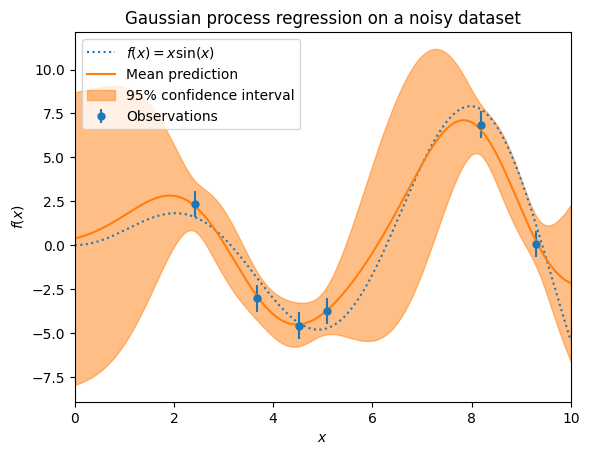

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

X = np.linspace(0., 10., 1000).reshape(-1, 1)

# Function to gregress
y = np.squeeze(X * np.sin(X))

# Randomly choose some x-coordinates where we have observations
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

# Get noisy observations
noise_std = 0.75
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)

# Do the Gaussian Process regression using an RBF kernel
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(
    kernel=kernel, alpha=noise_std**2, n_restarts_optimizer=9
)
gaussian_process.fit(X_train, y_train_noisy)

# Predict function and variance at unknown locations
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.errorbar(
    X_train,
    y_train_noisy,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlim([0.,10.])
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.title("Gaussian process regression on a noisy dataset")

## Kernels
- There are many choices of the covariance kernel for different applications such as the Matern kernel and periodic kernel which assumes periodicity in the Gaussian process
- GPytorch implements a large number of covariance kernels and allows for custom [kernels](https://docs.gpytorch.ai/en/v1.11/kernels.html)
- Gpytorch even allows for a learned neural network based covariance kernel

# Applications in Glaciology



- GP's have many useful applications in Glaciology
- Can be used for interpolation of unknown variables
- GP's can be used as priors over functions for inverse problems, variational inference (e.g. [this paper](https://www.sciencedirect.com/science/article/pii/S0021999122001577) from Doug / other examples [here](https://arxiv.org/pdf/2112.13663))
- GP's can be used for emulation (e.g. [Edwards et al. 2021](https://research-repository.st-andrews.ac.uk/bitstream/handle/10023/24263/Edwards_2021_Nature_Projectedlandice_AAM.pdf?sequence=1&isAllowed=y)).

## Example

- [Downs et al. 2022](https://www.cambridge.org/core/journals/journal-of-glaciology/article/inferring-timedependent-calving-dynamics-at-helheim-glacier/D678DCC319C0228A087701B315E4C971) uses a GP emulator to estimate uncertain model parameters for Helheim glacier
- Idea is to infer parameters that lead to best agreement between modeled / observed terminus position
- An ensemble of model runs is performed with different model parameters
- Then a GP is used to estimate mismatch between observations / model for arbitrary parameters based on this ensemble data
- GP fills in the gaps between unknown parameters and allows for fast MCMC sampling
- FIgure below shows an example of model parameters inferred from MCMC using the GP emulator
- This sampling would be intractable without emulation

<div>
<img src="https://github.com/glamacles/notebooks/blob/main/images/gaussian_processes/emulator.png?raw=1" width="700"/>
</div>